# Business Understanding
The aerospace and defense industry reported $\$$712 billion of revenue in 2021 (up 4\% over 2020), and $62 billion of operating profit (up 136%), according to PwC analysis. Recently, NASA smashed it's Dart probe into an asteroid, destoyring itself in the process. The collision was intentional and designed to test whether space rocks that might threaten Earth could be pushed safely out of the way. Reports indicate that the Dart probe was a mere 17 meters off the exact centre of the asteroid. NASA and the aerospace industry are capable of traveling further than they ever have, navigating to specific locations, and capturing photos, recording video and taking samples.

But, <b>"Houston, we have a problem."</b> And it's that there aren't enough scientists to review all the collected images and classify them. We at <b>Image Science and Analysis Group (ISAG)</b> have built a model that <b>"takes one giant leap"</b> over this problem. <b>First</b>, our model can identify landmarks types and contribute to mapping out the terain on Mars. <b>Second</b>, we can also identify other unclassifiable landmarks or features. The images classified as other may foster efforts to select sites of interest to explore during manned or unnmanned missions. At it's core, our model let's us know what we're looking at and if doesn't then it lures to a new place we could go. In this way, image science is part and parcel of <b>space exploration</b> and discovery and our group can help <b>NASA</b> further this mission.


# Imports

In [1]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.dummy import DummyClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

tf_chkpt_path = 'tf_TransferLearning_8Classes'

from src.image_functions import *

# Train

In [2]:
# Normalize and rescale the images
train_datagen = ImageDataGenerator(rescale=1./255)

# Pull images from 'images/train'
train_generator = train_datagen.flow_from_directory(
    'images/train/',
    target_size = (227, 227),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical')

Found 48979 images belonging to 8 classes.


# Validation

In [3]:
# Normalize and rescale the images
val_datagen = ImageDataGenerator(rescale=1./255)

# Pull images from 'images/val'
val_generator = val_datagen.flow_from_directory(
    'images/val/',
    target_size = (227, 227),
    batch_size=16,
    color_mode='rgb',
    class_mode='categorical')

Found 14175 images belonging to 8 classes.


# Models
## Dummy

In [4]:
# Create dummy baseline model
dummy = DummyClassifier(strategy='most_frequent')

# Fit dummy model on train 
dummy.fit(train_generator.filenames,
          train_generator.classes)

# Score dummy model
dummy.score(train_generator.filenames,
            train_generator.classes)

0.8170644561955124

We can tell that <b>81%</b> of the data belongs to the <b>other</b> class. Our model sets out to perform better than this <b>baseline</b> score.

## Callbacks 
`CSVLogger` callback will create a log file that'll <b>record</b> the model's metrics (<b>loss, accuracy, val_loss, val_accuracy,</b> and <b>learning rate</b>) after every epoch. We'll visualize these metrics below using lineplots.

In [5]:
csv_logger = CSVLogger('./logs/TransferLearning_VGG16_Logger_3.log', separator=',', append=False)

`EarlyStop` enable us to <b>stop</b> the model early <b>if validation accuracy does not increase</b> after a few epochs. 

In [6]:
early_stop = EarlyStopping(monitor='val_accuracy',
                           verbose=1,
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

We're going to use the `LearningRateScheduler` callback to adjust the model's learning rate while it trains on the data. We don't want our model to have too high of a learning rate otherwise our model may not converge and bounce past the optimal solution. We don't want our learning rate to be too low either because the model will have to train for a longer period of time.  We can address this dilemma with the `LearningRateScheduler`. <b>After 10 epochs</b> the <b>learning rate</b> will <b>decrease</b> after each epoch. This will enable our model to converge and find an optimal solution. 

In [7]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch > 50:
        return lr
    else:
        return lr * tf.math.exp(-0.01)
    
    
lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

We'll use `ModelCheckpoint` to <b>save</b> our model after each epoch. We're <b>monitoring</b> the <b>validation accuarcy</b> and ultimately <b>capturing</b> the <b>highest score</b>. When the best validation accuarcy score is beat it's replaced and overwritten. 

In [8]:
checkpoint = ModelCheckpoint(tf_chkpt_path+'_best_model_3.hdf5', 
                             monitor='val_accuracy', 
                             verbose=1,
                             save_best_only=True, 
                             mode='max', 
                             save_freq='epoch')

## VGG16 
- VGG16 is a type of CNN (Convolutional Neural Network). It can classify 1000 images of 1000 different categories with 92.7% accuracy. It's a popular algorithm for image classification and it's easy to use with transfer learning.<br>
<br>
- The "16" in VGG16 refers to 16 layers that have weights. In VGG16 there are 13 convolutional layers, 5 Max Pooling layers, and 3 Dense layers which add up to 21 layers but it only has 16 weight layers.<br>
<br>
- VGG16 input is an image of dimensions (224, 224, 3).<br>
<br>
<img src="images/notebook/vgg-16_architecture.jpg" width="900" height="900">
<br>
- What's unique about VGG16 is that it uses of a very small 3 x 3 receptive field (filters) throughout the network with the stride of 1 pixel. 2 consecutive 3 x 3 filters provide an effective receptive field of 5 x 5. Likewise, three 3 x 3 filters compensate for a receptive field of 7 x 7. This way, a combination of many 3 x 3 filters can compensate for a receptive area of a larger size.<br>
<br>
- It also significantly lowers the number of weight parameters in the model. For example, the input and output of a three-layer 3 x 3 convolutional stack have C channels, the number of weight parameters are 3 * 32 C2 = 27 C2. Compared to a 7 x 7 convolutional layer, it requires 72 C2 = 49 C2, which is nearly twice the 3 x 3 layers. Furthermore, this can be seen as a regularization on the 7 x 7 convolutional filters forcing them to have a decomposition through the 3 x 3 filters, with non-linearity added in-between via ReLU activations. This lowers the likihood that the model will over-fit while it's training.<br>
<br>

<img src="images/notebook/vgg-16_input_output.png" width="1000" height="1000"><br>

- Additionaly, Conv-1 Layer has 64 number of filters, Conv-2 has 128 filters, Conv-3 has 256 filters, Conv 4 and Conv 5 has 512 filters.<br>
<br>
- 3 Fully-Connected (FC) layers follow a stack of convolutional layers: the first two have 4096 channels each, the third performs 1000-way ILSVRC classification and thus contains 1000 channels (one for each class). The final layer is the soft-max layer.

In [9]:
# Create VGG16 model
vgg = tf.keras.applications.vgg16.VGG16(include_top=False,
                                        weights='imagenet', # Pretrain on ImageNet
                                        classes=8, # Number of classes
                                        classifier_activation='softmax', # Multiclass
                                        input_shape=(227, 227, 3)) # 3 is RGB

Even though our data is in <b>grayscale, VGG16</b> is designed to work with <b>RGB</b> images that have a size of <b>224 x 224</b>, so we loaded our images that way. Then we `Flatten` and add a `Dense` layer matching the number of classes (8) and set activation to *'softmax'* for multiclass. Laslty, we add the `VGG16` layer.

In [10]:
# Create Sequential model
model = tf.keras.Sequential([vgg,
                             layers.Flatten(),
                             layers.Dense(8, activation='softmax')])

# View model summary
model.summary()

# Compile the modelwith Adam optimizer and learning rate of 0.00001
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss=losses.CategoricalCrossentropy(), # Set to CategoricalCrossentropy because we have 8 classes (multiclass)
              metrics='accuracy') # Track accuracy

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 8)                 200712    
                                                                 
Total params: 14,915,400
Trainable params: 14,915,400
Non-trainable params: 0
_________________________________________________________________


Due to tech limitations I ran this model with no more than 15 epochs at a time. I <b>saved</b> all the <b>log metrics</b> for every epoch and the model that produced the <b>best validation accuracy score</b>.

In [11]:
# Fit the model
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=10,
                    validation_data=val_generator,
                    verbose=1,
                    workers=16,
                    callbacks=[lr,
                               csv_logger,
                               checkpoint])
# 174

# Visualizations
Here, we line plot the loss and for the validation and train sets. Our best validaiton accuracy was <b>90.5%</b>, a  <b>10%</b> improvement over the dummy model, but we <b>don't see</b> the loss or accuracy reach a <b>good fit</b> point.

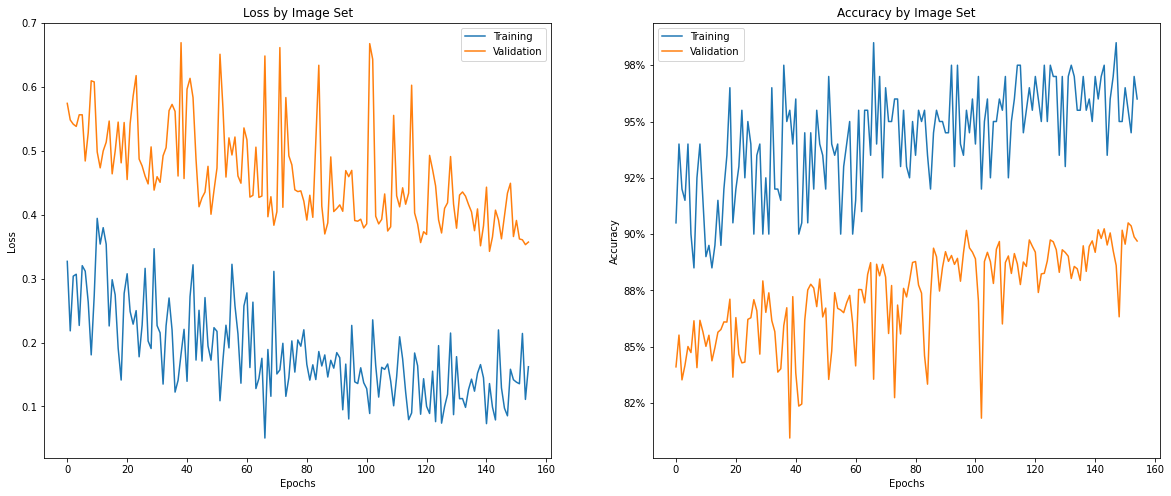

In [12]:
# Access the log metrics for all the epochs
model_log = pd.read_csv('./logs/TransferLearning_VGG16_Logger.log')

# Access train loss and accuracy
train_loss = model_log['loss']
train_acc = model_log['accuracy']    

# Access validation loss and accuracy
val_loss = model_log['val_loss']
val_acc = model_log['val_accuracy']

# Create 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot train loss then validation loss
ax1.plot(model_log['epoch'], train_loss)
ax1.plot(model_log['epoch'], val_loss)

# Label the subplot, x-axis, and y-axis
ax1.set_title('Loss by Image Set')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(['Training', 'Validation'])

# Plot train accurac then validation accuracy
ax2.plot(model_log['epoch'], train_acc)
ax2.plot(model_log['epoch'], val_acc)

# Label the subplot, x-axis, and y-axis
ax2.set_title('Accuracy by Image Set')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(['Training', 'Validation'])

# Set yticks to percentages
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(f'{round(x*100)}%')))

# Save trhe figure in the figures folder
plt.savefig('./figures/loss_acc_vgg16.jpg', 
            dpi='figure', 
            bbox_inches='tight', 
            pad_inches=0.1,
            facecolor='auto', edgecolor='auto');

# Final Model
## Validation

In [13]:
# Load the best model and save it as an .hfpy file
model = models.load_model('tf_TransferLearning_8Classes_best_model.hdf5')
model.save('tf_TransferLearning_8class_VGG16.hfpy')
model = tf.keras.models.load_model('tf_TransferLearning_8class_VGG16.hfpy')

INFO:tensorflow:Assets written to: tf_TransferLearning_8class_VGG16.hfpy\assets


1418/1418 [==============================] - 1403s 989ms/step - loss: 0.3622 - accuracy: 0.9050
[0.3622171878814697, 0.904973566532135]


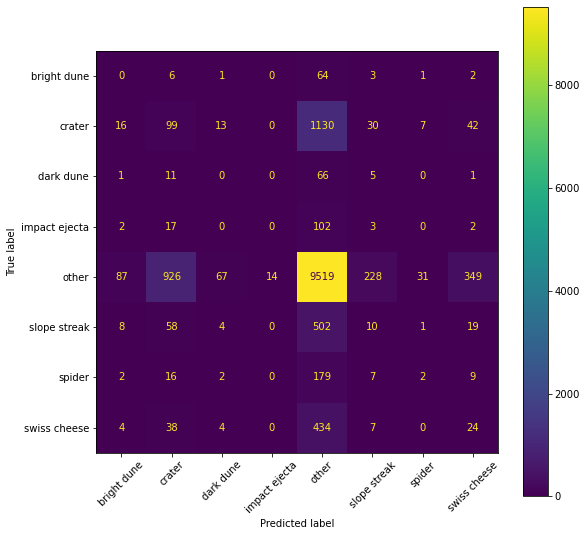

In [14]:
# Evaluate the model
print(model.evaluate(val_generator))

val_actual = val_generator.classes
val_pred_proba = model.predict(val_generator)
val_pred = np.argmax(val_pred_proba, axis=1)

# Create and plot confusion matrix
fig, ax = plt.subplots(figsize=(9, 9))
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(val_actual, val_pred),
                                     display_labels=val_generator.class_indices)
conf_matrix.plot(ax=ax, 
                 cmap='viridis')
plt.xticks(rotation=45)
plt.savefig('./figures/confusion_matrix_vgg16_val.jpg');

Best performing VGG16 model achieved a <b>validation accuracy</b> score of <b>90.5%</b> and a <b>validation loss</b> score of  <b>0.3622</b>.

## Test

In [15]:
# Normalize and rescale the images
test_datagen = ImageDataGenerator(rescale=1./255)

# Pull images from 'images/test'
test_generator = test_datagen.flow_from_directory('images/test/',
                                                  target_size=(227, 227),
                                                  batch_size=1,
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 1793 images belonging to 8 classes.


In [16]:
test_actual = test_generator.classes
test_pred_proba = model.predict(test_generator)
test_pred = np.argmax(test_pred_proba, axis=1)

               precision    recall  f1-score   support

  bright dune       0.52      0.94      0.67        16
       crater       0.78      0.78      0.78        89
    dark dune       0.90      0.56      0.69        66
impact ejecta       0.44      0.57      0.50         7
        other       0.93      0.98      0.95      1482
 slope streak       1.00      0.45      0.62        49
       spider       0.00      0.00      0.00        42
 swiss cheese       1.00      0.95      0.98        42

     accuracy                           0.91      1793
    macro avg       0.70      0.65      0.65      1793
 weighted avg       0.90      0.91      0.90      1793

1793/1793 [==============================] - 248s 139ms/step - loss: 0.3928 - accuracy: 0.9141
[0.39277270436286926, 0.9141104221343994]


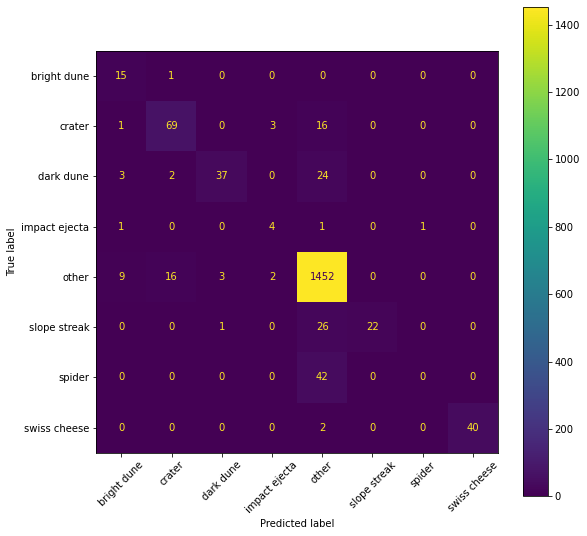

In [17]:
# View classification report
print(classification_report(test_actual, 
                            test_pred, 
                            target_names=test_generator.class_indices))

# Evaluate the model
print(model.evaluate(test_generator))

# Create and plot confusion matrix
fig, ax = plt.subplots(figsize=(9, 9))
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(test_actual, test_pred),
                                     display_labels=test_generator.class_indices)
conf_matrix.plot(ax=ax,
                 cmap='viridis')
plt.xticks(rotation=45)
plt.savefig('./figures/confusion_matrix_vgg16_test.jpg');

Best performing VGG16 model achieved a <b>test accuracy</b> score of <b>91.4%</b> and a <b>test loss</b> score of  <b>0.3928</b>. It has performed very well on unseen data.